# EV State of Charge: Distribution of inital and final SoC

## Data Preparation

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Load the Dataset

In [2]:
# Replace 'path_to_file.xlsx' with the actual path to your Excel file
file_path = '../data/raw/epfl_session_data.xlsx'
data = pd.read_excel(file_path)

### Inspect the Dataset

In [3]:
# Display the first few rows to understand its structure
data.sample(5)

,Session,CCS,Arrival,Departure,Stay (min),Energy (Wh),Pmax (W),Preq_max (W),"Controlled session (0=False, 1=True)",TotalCapacity,BulkCapacity,SOC arrival,SOC departure,Energy capacity (Wh)
1749,1522,CCS2,2022-12-05 21:52:00,2022-12-05 22:50:00,59,57489.0,103401,120222,1,10000,8000,22.0,90.0,80315.514706
1260,858,CCS1,2023-04-14 15:52:00,2023-04-14 16:29:00,38,26782.0,71169,142737,0,10000,8000,35.0,81.0,55310.652174
491,512,CCS1,2022-11-13 15:53:00,2022-11-13 16:13:00,21,41385.0,170127,177540,1,10000,8000,31.0,80.0,80236.224490
1189,1070,CCS1,2023-06-23 15:23:00,2023-06-23 15:58:00,36,46726.0,149856,353265,1,10000,8000,27.0,86.0,75236.779661
300,378,CCS1,2022-10-27 13:10:00,2022-10-27 13:26:00,17,18558.0,92655,110514,0,50000,40000,13.0,52.0,45205.384615


### Preprocessing

In [4]:
# Step 4: Preprocessing
# Check for missing or invalid data in these columns
initial_soc_col = 'SOC arrival'
final_soc_col = 'SOC departure'

# Ensure the necessary columns exist in the dataset
if initial_soc_col in data.columns and final_soc_col in data.columns:
    # Drop rows with missing or invalid SOC values
    data = data[[initial_soc_col, final_soc_col]].dropna()

    # Remove outliers if applicable (e.g., SOC should be between 0 and 100)
    data = data[(data[initial_soc_col] >= 0) & (data[initial_soc_col] <= 100)]
    data = data[(data[final_soc_col] >= 0) & (data[final_soc_col] <= 100)]

    # Round SOC values to the nearest integer
    data[initial_soc_col] = data[initial_soc_col].round()
    data[final_soc_col] = data[final_soc_col].round()

else:
    raise ValueError(f"The dataset does not contain required columns '{initial_soc_col}' and '{final_soc_col}'")


## Plots of Distributions

### Initial SOC Distribution

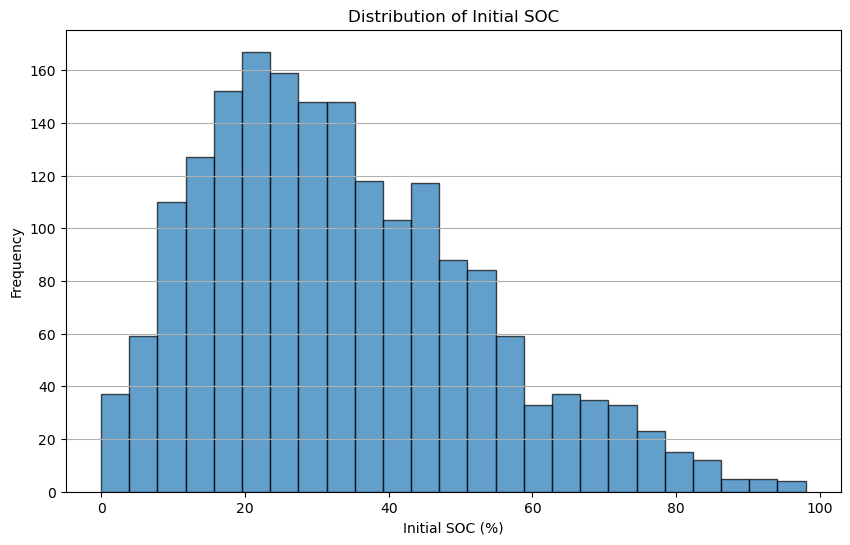

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(data[initial_soc_col], bins=25, alpha=0.7, edgecolor='black')
plt.title('Distribution of Initial SOC')
plt.xlabel('Initial SOC (%)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

### Final SOC Distribution

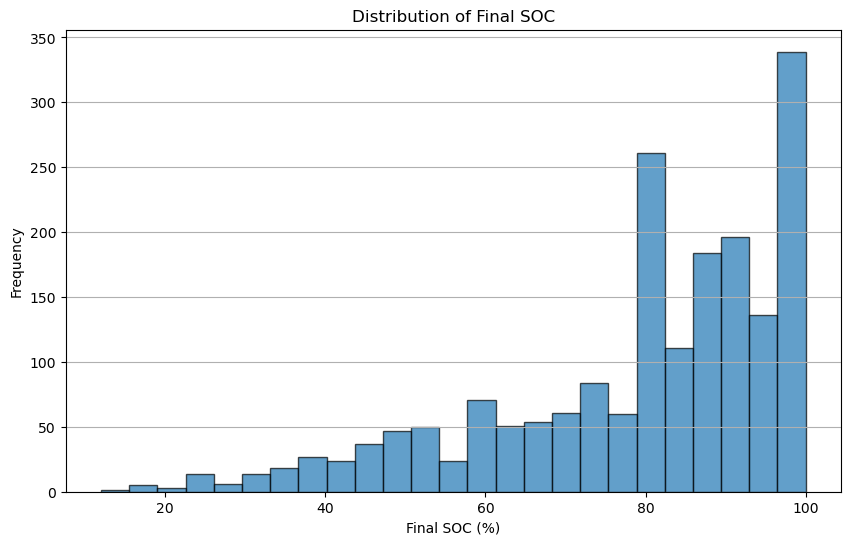

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(data[final_soc_col], bins=25, alpha=0.7, edgecolor='black')
plt.title('Distribution of Final SOC')
plt.xlabel('Final SOC (%)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

## Bivariate Model Fitting: Keep coupling between initial and final SoC

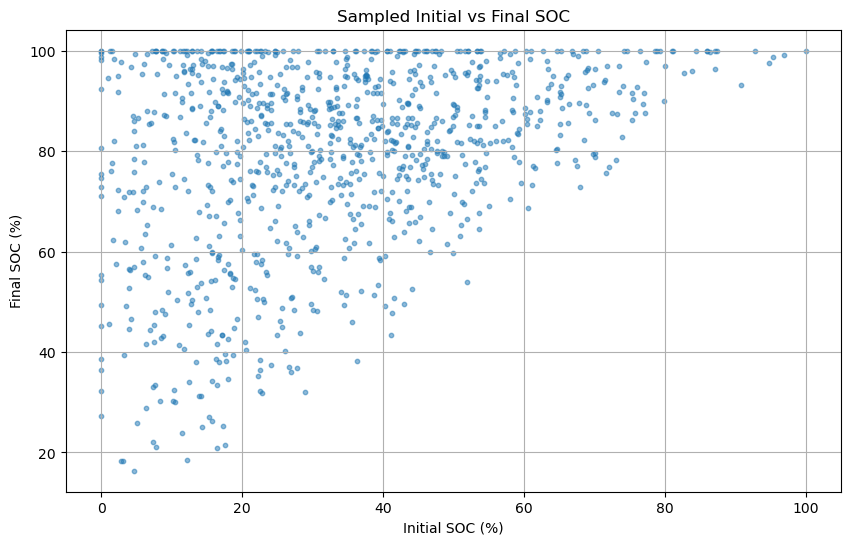

In [9]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Step 1: Extract Initial and Final SOC
initial_soc = data[initial_soc_col].values
final_soc = data[final_soc_col].values

# Combine into a 2D array (each row is a pair [initial_soc, final_soc])
paired_data = np.vstack([initial_soc, final_soc])

# Step 2: Fit a Multivariate KDE
kde = gaussian_kde(paired_data, bw_method='scott')  # 'scott' or 'silverman' for bandwidth

# Step 3: Sample from the KDE
num_samples = 1000
sampled_pairs = kde.resample(num_samples)  # Result is a 2D array: [initial_soc_samples, final_soc_samples]

# Convert to individual arrays for convenience
sampled_initial_soc = sampled_pairs[0]
sampled_final_soc = sampled_pairs[1]

# Step 4: Apply Logical Constraints (e.g., final_soc >= initial_soc)
# Optionally clamp values to valid ranges (0 to 100)
valid_samples = sampled_initial_soc <= sampled_final_soc
sampled_initial_soc = sampled_initial_soc[valid_samples]
sampled_final_soc = sampled_final_soc[valid_samples]

# Further clamp to the range [0, 100]
sampled_initial_soc = np.clip(sampled_initial_soc, 0, 100)
sampled_final_soc = np.clip(sampled_final_soc, 0, 100)

# Plot the joint distribution of sampled data
plt.figure(figsize=(10, 6))
plt.scatter(sampled_initial_soc, sampled_final_soc, alpha=0.5, s=10)
plt.title('Sampled Initial vs Final SOC')
plt.xlabel('Initial SOC (%)')
plt.ylabel('Final SOC (%)')
plt.grid(True)
plt.show()

In [10]:
import pickle

# Save the KDE model
with open('initial_final_soc_kde.pkl', 'wb') as file:
    pickle.dump(kde, file)

In [15]:
# Test it out
sampled_pairs = kde.resample(1)
sampled_initial_soc = sampled_pairs[0]
sampled_final_soc = sampled_pairs[1]

In [17]:
sampled_pairs[0][0]

np.float64(4.782762098956829)